In [1]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.utils.time_series import TimeSeries
from ts_datasets.forecast import M4


100%|██████████| 414/414 [00:00<00:00, 553.81it/s]


Has missing data: False


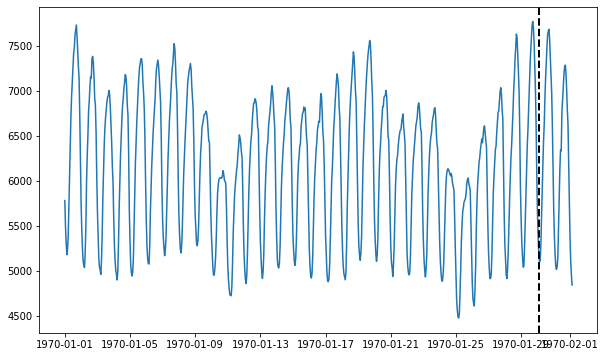

700 points in train split, 48 points in test split.


In [2]:
# Load the time series
# time_series is a time-indexed pandas.DataFrame
# trainval is a time-indexed pandas.Series indicating whether each timestamp is for training or testing
time_series, metadata = M4(subset="Hourly")[5]
trainval = metadata["trainval"]

# Is there any missing data?
timedeltas = np.diff(time_series.index)
print(f"Has missing data: {any(timedeltas != timedeltas[0])}")

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(time_series[trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

# Split the time series into train/test splits, and convert it to Merlion format
train_data = TimeSeries.from_pd(time_series[trainval])
test_data  = TimeSeries.from_pd(time_series[~trainval])
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")


In [3]:
import jax.numpy as jnp

def relu(x):
    return jnp.maximum(0.0, x)

def mlp(params, inputs):
# A multi-layer perceptron, i.e. a fully-connected neural network.
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b  # Linear transform
        inputs = jnp.tanh(outputs)            # Nonlinearity
    return outputs

In [4]:
def nn_dynamics(state, time, params):
    state_and_time = jnp.hstack([state, jnp.array(time)])
    return mlp(params, state_and_time)

In [37]:
from jax.experimental.ode import odeint

def odenet(params, input):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params, atol=0.001, rtol=0.001)
    return final_state

In [38]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [40]:
inputs = jnp.reshape(np.array(train_data.time_stamps)[:50], (50, 1))
targets = jnp.reshape(train_data.to_pd()['H6'].values[:50], (50, 1))
# inputs
# inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
# targets = inputs**3 + 0.1 * inputs

In [93]:
from jax.config import config  
config.update("jax_debug_nans", True)

In [94]:
import numpy.random as npr
from jax import jit, grad

# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
    preds = batched_odenet(params, inputs)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def odenet_update(params, inputs, targets):
    grads = grad(odenet_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db)
                  for (w, b), (dw, db) in zip(params, grads)]



In [95]:
# Initialize and train ODE-Net.
param_scale = 1.0
step_size = 0.01
train_iters = 10

odenet_params = init_random_params(param_scale, odenet_layer_sizes)



In [96]:
for i in range(train_iters):
    odenet_params = odenet_update(odenet_params, inputs, targets)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit/pmap-ed function. Calling the de-optimized version.
Invalid value encountered in the output of a jit/pmap-ed function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in dot_general

In [ ]:
batched_odenet(odenet_params, inputs)

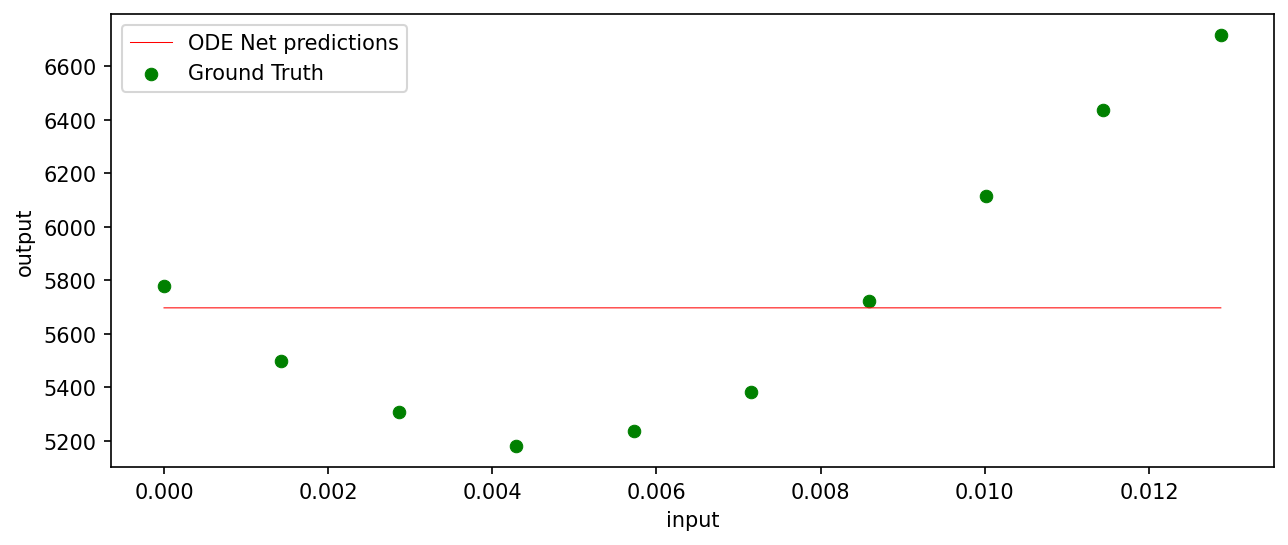

In [26]:
# Plot resulting model.
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(scaler.transform(np.array(train_data.time_stamps[0:10]).reshape(-1,1)), (10, 1))
# fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 10), (10, 1))
ax.plot(fine_inputs, batched_odenet(odenet_params, inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(("ODE Net predictions","Ground Truth"))

In [3]:
from merlion.models.forecast.base import ForecasterConfig

class RepeatRecentConfig(ForecasterConfig):
    def __init__(self, max_forecast_steps=None, **kwargs):
        super().__init__(max_forecast_steps=max_forecast_steps, **kwargs)


In [4]:
from collections import OrderedDict
from typing import List, Tuple

from merlion.models.forecast.base import ForecasterBase
from merlion.utils import TimeSeries, UnivariateTimeSeries


class RepeatRecent(ForecasterBase):
    # The config class for RepeatRecent is RepeatRecentConfig, defined above
    config_class = RepeatRecentConfig

    def __init__(self, config):
        """
        Sets the model config and any other local variables. Here, we initialize
        the most_recent_value to None.
        """
        super().__init__(config)
        self.most_recent_value = None


    def train(self, train_data: TimeSeries, train_config=None) -> Tuple[TimeSeries, None]:
        # Apply training preparation steps. We specify that this model doesn't
        # require evenly sampled time series, and it doesn't require univariate
        # data.
        train_data = self.train_pre_process(
            train_data, require_even_sampling=False, require_univariate=False)

        # "Train" the model. Here, we just gather the most recent values
        # for each univariate in the time series.
        self.most_recent_value = OrderedDict((k, v.values[-1])
                                             for k, v in train_data.items())

        # The model's "prediction" for the training data, is just the value
        # from one step before.
        train_forecast = TimeSeries(OrderedDict(
            (name, UnivariateTimeSeries(univariate.time_stamps,
                                        [0] + univariate.values[:-1]))
            for name, univariate in train_data.items()))

        # This model doesn't have any notion of error
        train_stderr = None

        # Return the train prediction & standard error
        return train_forecast, train_stderr

    def forecast(self, time_stamps: List[int],
                 time_series_prev: TimeSeries = None,
                 return_iqr=False, return_prev=False
                ) -> Tuple[TimeSeries, None]:

        # Use time_series_prev's most recent value if time_series_prev is given.
        # Make sure to apply the data pre-processing transform on it first!
        if time_series_prev is not None:
            time_series_prev = self.transform(time_series_prev)
            most_recent_value = {k: v.values[-1] for k, v in time_series_prev.items()}

        # Otherwise, use the most recent value stored from the training data
        else:
            most_recent_value = self.most_recent_value

        # The forecast is just the most recent value repeated for every upcoming
        # timestamp
        forecast = TimeSeries(OrderedDict(
            (k, UnivariateTimeSeries(time_stamps, [v] * len(time_stamps)))
            for k, v in most_recent_value.items()))

        # Pre-pend time_series_prev to the forecast if desired
        if return_prev and time_series_prev is not None:
            forecast = time_series_prev + forecast

        # Ensure we're not trying to return an inter-quartile range
        if return_iqr:
            raise RuntimeError(
                "RepeatRecent model doesn't support uncertainty estimation")

        return forecast, None



In [10]:
OrderedDict((k, v.values[-1]) for k, v in train_data.items())

OrderedDict([('H6', 5104.0)])

In [5]:
# Initialize a model & train it. The dataframe returned & printed
# below is the model's "forecast" on the training data. None is
# the uncertainty estimate.
model = RepeatRecent(RepeatRecentConfig())
model.train(train_data=train_data)


(                         H6
 1970-01-01 00:00:00     0.0
 1970-01-01 01:00:00  5780.0
 1970-01-01 02:00:00  5497.0
 1970-01-01 03:00:00  5306.0
 1970-01-01 04:00:00  5178.0
 ...                     ...
 1970-01-29 23:00:00  6629.0
 1970-01-30 00:00:00  6077.0
 1970-01-30 01:00:00  5644.0
 1970-01-30 02:00:00  5380.0
 1970-01-30 03:00:00  5174.0
 
 [700 rows x 1 columns],
 None)

In [6]:
# Let's run our model on the test data now
forecast, err = model.forecast(test_data.to_pd().index)
print("Forecast")
print(forecast)
print()
print("Error")
print(err)


Forecast
                         H6
1970-01-30 04:00:00  5104.0
1970-01-30 05:00:00  5104.0
1970-01-30 06:00:00  5104.0
1970-01-30 07:00:00  5104.0
1970-01-30 08:00:00  5104.0
1970-01-30 09:00:00  5104.0
1970-01-30 10:00:00  5104.0
1970-01-30 11:00:00  5104.0
1970-01-30 12:00:00  5104.0
1970-01-30 13:00:00  5104.0
1970-01-30 14:00:00  5104.0
1970-01-30 15:00:00  5104.0
1970-01-30 16:00:00  5104.0
1970-01-30 17:00:00  5104.0
1970-01-30 18:00:00  5104.0
1970-01-30 19:00:00  5104.0
1970-01-30 20:00:00  5104.0
1970-01-30 21:00:00  5104.0
1970-01-30 22:00:00  5104.0
1970-01-30 23:00:00  5104.0
1970-01-31 00:00:00  5104.0
1970-01-31 01:00:00  5104.0
1970-01-31 02:00:00  5104.0
1970-01-31 03:00:00  5104.0
1970-01-31 04:00:00  5104.0
1970-01-31 05:00:00  5104.0
1970-01-31 06:00:00  5104.0
1970-01-31 07:00:00  5104.0
1970-01-31 08:00:00  5104.0
1970-01-31 09:00:00  5104.0
1970-01-31 10:00:00  5104.0
1970-01-31 11:00:00  5104.0
1970-01-31 12:00:00  5104.0
1970-01-31 13:00:00  5104.0
1970-01-31 

Forecast w/ ground truth time series


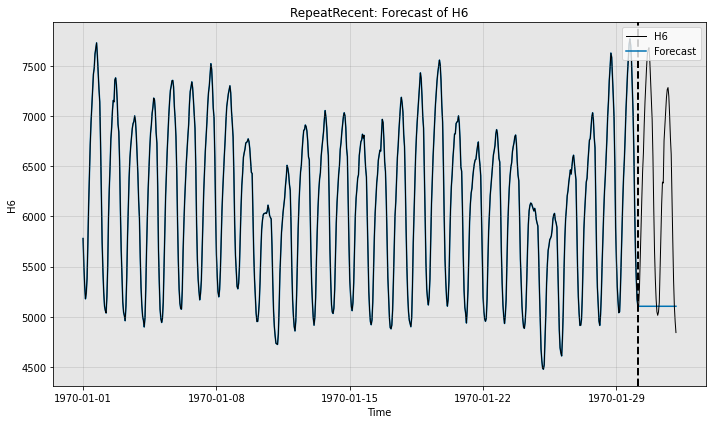


Forecast without ground truth time series


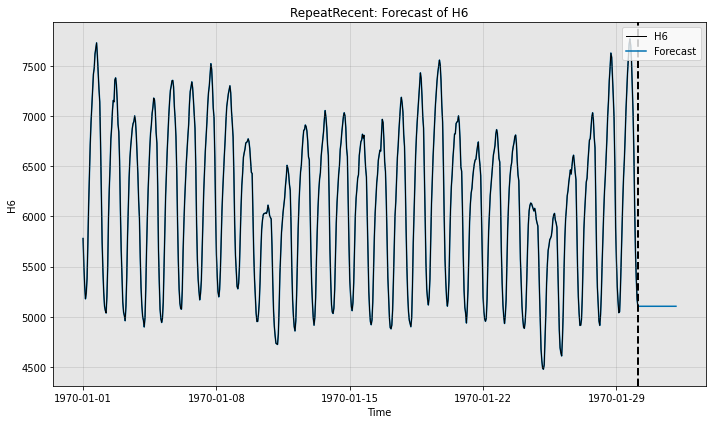

In [7]:
# Qualitatively, we can see what the forecaster is doing by plotting
print("Forecast w/ ground truth time series")
fig, ax = model.plot_forecast(time_series=test_data,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)
plt.show()

print()
print("Forecast without ground truth time series")
fig, ax = model.plot_forecast(time_stamps=test_data.to_pd().index,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)


In [8]:
from merlion.evaluate.forecast import ForecastMetric
smape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast)
print(f"sMAPE = {smape:.3f}")


sMAPE = 20.702
